In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from functools import partial
from utils import chart_price, plot, perf, v_backtester, c_backtester, perf_var
import sys
from functools import partial
sys.path.append('/home/tomek/ib_tools')
from indicators import get_ATR, get_signals
from candlesticks import candlesticks
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
time_int = 30
periods = 100
multi_periods = [5, 10, 20, 40, 80, 160]
#multi_periods = [2, 5, 7, 10, 12, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 160, 320] 
#multi_periods = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 40, 60, 80, 100, 120, 140, 160] 
roc_periods = [5, 10]
vol_lookback = 200
smooth = int(np.ceil(periods/4))
atr_periods = 80

In [3]:
contract = pd.read_pickle('data/minute_NQ_cont_non_active_included.pickle')
contract = contract.loc['20190101': '20191231']

In [4]:
avg_vol = contract.volume.rolling(time_int).sum().mean()
avg_vol

9915.49165665634

In [5]:
vol_candles = group_by_volume(contract, avg_vol)

In [6]:
data = pd.DataFrame({'date': vol_candles.date,
                     'open': vol_candles.open,
                     'close': vol_candles.close})

In [7]:
def ema(data, periods):
    data = data.copy()
    data['ema_fast'] = data.close.ewm(span=periods).mean()
    data['ema_slow'] = data.close.ewm(span=periods*3).mean()
    up = (data.ema_fast > data.ema_slow) * 1
    down = (data.ema_fast < data.ema_slow) * 1
    return up - down

In [8]:
def breakout(data, periods):
    up  = (data.close >= data.close.rolling(periods).max()) * 1
    down = (data.close <= data.close.rolling(periods).min()) * 1
    return (up - down).rename(periods, inplace=True)

In [9]:
def diff(data, periods):
    up = (data.close.diff(periods) > 0) * 1
    down = (data.close.diff(periods) < 0) * 1
    return (up - down).rename(periods, inplace=True)

In [10]:
def acc(data, periods):
    up = (data.close.pct_change(periods).pct_change(periods) > 0) * 1
    down = (data.close.pct_change(periods).pct_change(periods) < 0) * 1
    return (up - down).rename(periods, inplace=True)

In [11]:
def vol(data, vol_lookback):
    data = data.copy()
    data['returns'] = data['close'].pct_change()
    data['vol_returns'] = data['returns'].ewm(span=vol_lookback, min_periods=int(vol_lookback*.9)).std()
    data['vol_price'] = data['vol_returns'] * data['close']
    return data['vol_price']

In [12]:
vols = vol(data, vol_lookback)

In [13]:
def combine(data, multi_periods, funcs):
    result = pd.DataFrame()
    for func in funcs:
        result[func.__name__] = pd.DataFrame([func(data, p) for p in multi_periods]).T.sum(axis=1)
    return result

In [14]:
forecasts = pd.DataFrame([acc(data, p) for p in multi_periods]).T

In [15]:
multiplier = 10/forecasts.mean(axis=1).abs().mean()
multiplier

18.160526957794584

In [16]:
forecasts.abs().mean()

5      0.998657
10     0.997313
20     0.994627
40     0.989253
80     0.978506
160    0.957012
dtype: float64

In [17]:
multi = 10/forecasts.abs().mean()
multi

5      10.013452
10     10.026940
20     10.054025
40     10.108637
80     10.219660
160    10.449186
dtype: float64

In [18]:
scaled_forecasts = (forecasts *multi).clip(lower=-20, upper=20)
scaled_forecasts

,5,10,20,40,80,160
label,,,,,,
0,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000
1,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000
2,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000
3,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000
4,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000
...,...,...,...,...,...,...
7439,-10.013452,-10.02694,-10.054025,-10.108637,-10.21966,-10.449186
7440,-10.013452,-10.02694,-10.054025,-10.108637,-10.21966,-10.449186
7441,-10.013452,-10.02694,-10.054025,-10.108637,-10.21966,-10.449186


In [19]:
scaled_forecasts.abs().mean()

5      10.0
10     10.0
20     10.0
40     10.0
80     10.0
160    10.0
dtype: float64

In [20]:
scaled_forecasts.corr()

,5,10,20,40,80,160
5,1.000000,0.117353,0.047946,0.008004,0.019607,0.014927
10,0.117353,1.000000,0.107069,0.039578,0.028562,0.008547
20,0.047946,0.107069,1.000000,0.110904,0.042373,0.012404
40,0.008004,0.039578,0.110904,1.000000,0.085602,0.037659
80,0.019607,0.028562,0.042373,0.085602,1.000000,0.149369
160,0.014927,0.008547,0.012404,0.037659,0.149369,1.000000


In [21]:
combined_forecast = scaled_forecasts.mean(axis=1).ewm(span=5).mean().rename('combined')
combined_forecast

label
0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
7439   -7.411784
7440   -8.322962
7441   -8.930413
7442   -9.335381
7443   -9.605359
Name: combined, Length: 7444, dtype: float64

In [22]:
combined_forecast.abs().mean(), combined_forecast.abs().std()

(5.333393838302415, 2.6040497258504787)

In [23]:
#forecasts = (combine(data, multi_periods, [breakout])*multiplier).clip(lower=-20, upper=20)
#forecasts['diff'] = pd.DataFrame([diff(data, p) for p in roc_periods]).T.mean(axis=1)
#forecasts['combined'] = forecasts.sum(axis=1).ewm(span=50).mean()

In [24]:
data = data.join(combined_forecast*2.5)
data = data.iloc[200:]

In [25]:
#plot(data[['close',  'ema','combined']])

In [26]:
output = data.set_index('date')[['open','combined']]

In [27]:
stats = pd.DataFrame()
dailys = pd.DataFrame()
returns = pd.DataFrame()
for i in [0, .3, .5,1,2,3, 4,5,10, 11, 15]:
    b = v_backtester(output.open, output.combined, i)
    r = perf_var(b, False)
    stats[i] = r.stats
    dailys[i] = r.daily.balance
    returns[i] = r.daily['returns']

In [28]:
stats

,0.0,0.3,0.5,1.0,2.0,3.0,4.0,5.0,10.0,11.0,15.0
Annual return,-0.228592,-0.222654,-0.202551,-0.209427,-0.206175,-0.19829,-0.225729,-0.260071,-0.277926,-0.217435,-0.328631
Cumulative returns,-0.164065,-0.159628,-0.144681,-0.14978,-0.147367,-0.141528,-0.161924,-0.18777,-0.201355,-0.155735,-0.240512
Annual volatility,0.238917,0.23858,0.234156,0.240301,0.229465,0.218699,0.214619,0.204187,0.188607,0.177768,0.149964
Sharpe ratio,-0.967992,-0.937637,-0.850841,-0.859214,-0.892696,-0.902236,-1.08553,-1.37335,-1.63204,-1.29046,-2.58005
Calmar ratio,-0.842697,-0.833001,-0.773331,-0.777514,-0.72719,-0.777872,-0.866588,-0.971992,-1.1485,-0.921497,-1.27056
Stability,0.233573,0.237641,0.190801,0.202438,0.122841,0.160935,0.233082,0.261282,0.35803,0.163791,0.896053
Max drawdown,-0.271262,-0.267292,-0.261921,-0.269355,-0.283523,-0.254914,-0.26048,-0.267565,-0.241991,-0.235958,-0.258651
Omega ratio,0.847735,0.851042,0.863919,0.862402,0.860115,0.85977,0.835442,0.796518,0.758513,0.805079,0.638096
Sortino ratio,-1.46003,-1.42426,-1.30386,-1.33298,-1.37147,-1.37465,-1.637,-1.99767,-2.32329,-1.84275,-3.24389
Skew,1.00042,1.04366,1.07453,1.13831,1.0538,0.968779,0.967342,0.885844,0.766464,0.633648,-0.0970846


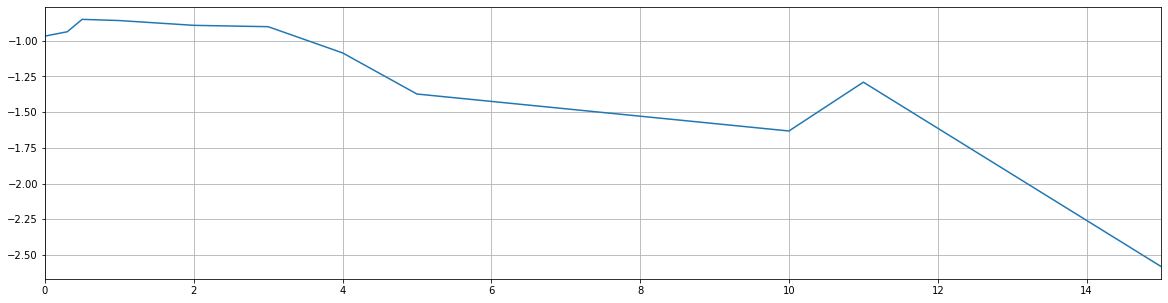

In [29]:
stats.loc['Sharpe ratio',].plot(figsize=(20,5), grid=True);

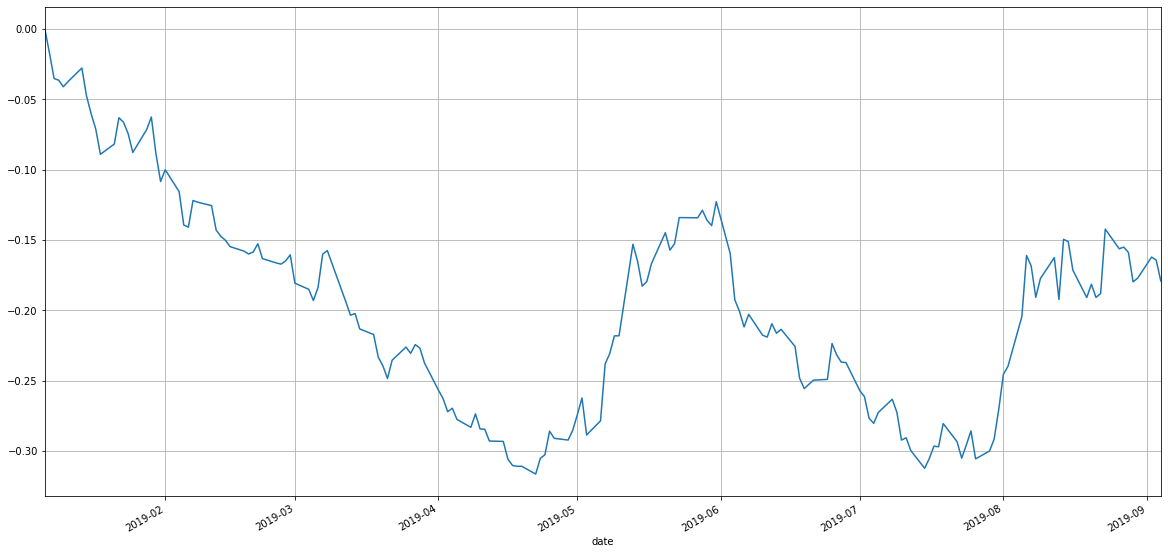

In [30]:
np.log(returns[0]+1).cumsum().plot(figsize=(20, 10), grid=True);

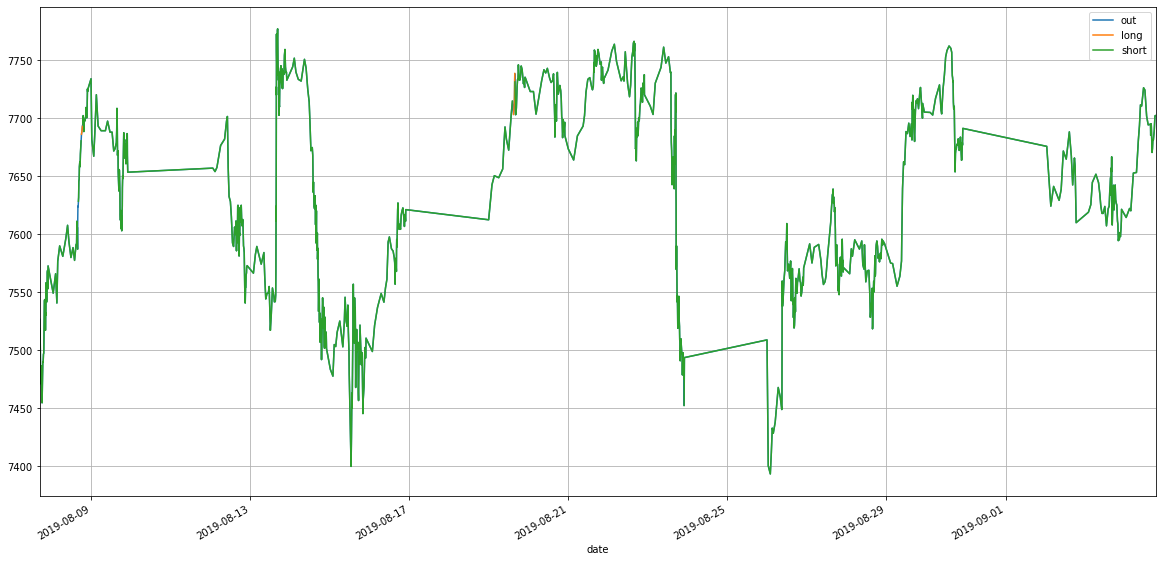

In [31]:
chart_price(output.open.iloc[-1000:], output.combined.iloc[-1000:], 0);